## Backtesting : 
Backtesting is, besides just “testing a trading strategy”, testing the strategy on relevant historical data to make sure that it’s an actual viable strategy before you start making moves. With backtesting, a trader can simulate and analyze the risk and profitability of trading with a specific strategy over a period of time

It consists of following essential components -
- A data handler, which is an interface to a set of data,
- A strategy, which generates a signal to go long or go short based on the data,
- A portfolio, which generates orders and manages Profit & Loss (also known as “PnL”), and

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot as plt

### The data handler is the pandas-datareader

In [3]:
nflx = DataReader('NFLX',  'yahoo', datetime(2014,1,1), datetime(2019,12,31));

### Trading Strategy

Here we create two separate Simple Moving Averages (SMA) of a time series with differing lookback periods, let’s say, 40 days and 100 days. If the short moving average exceeds the long moving average then you go long, if the long moving average exceeds the short moving average then you exit.

In [4]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=nflx.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = nflx['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = nflx['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2014-01-02     0.0   51.831429  51.831429        NaN
2014-01-03     0.0   51.851429  51.851429        0.0
2014-01-06     0.0   51.690000  51.690000        0.0
2014-01-07     0.0   50.892500  50.892500        0.0
2014-01-08     0.0   50.456571  50.456571        0.0


When you go long, you think that the stock price will go up and will sell at a higher price in the future (= buy signal); When you go short, you sell your stock, expecting that you can buy it back at a lower price and realize a profit (= sell signal).

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


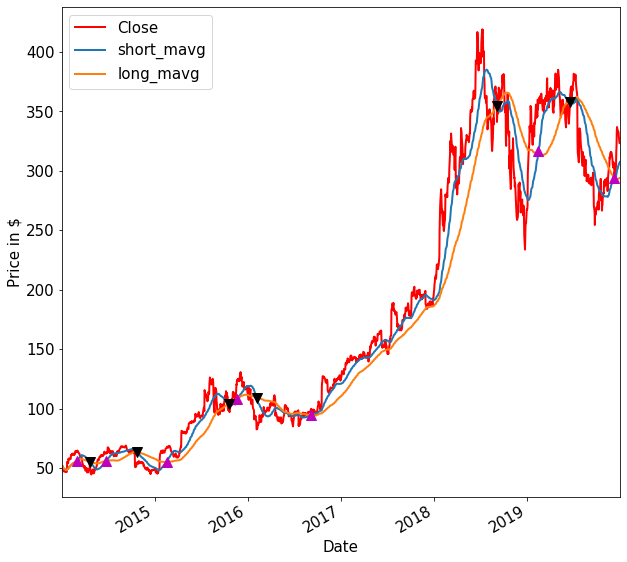

In [5]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure(figsize=(10, 10))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
nflx['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot

plt.legend()
plt.show()

Now we get started on creating a portfolio which can generate orders and manages the profit and loss:

### Portfolio

In [55]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['NFLX'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(nflx['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(nflx['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(nflx['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            NFLX  holdings      cash     total  returns
Date                                                   
2014-01-02   0.0       0.0  100000.0  100000.0      NaN
2014-01-03   0.0       0.0  100000.0  100000.0      0.0
2014-01-06   0.0       0.0  100000.0  100000.0      0.0
2014-01-07   0.0       0.0  100000.0  100000.0      0.0
2014-01-08   0.0       0.0  100000.0  100000.0      0.0


Calcluating Net Profit

In [15]:
sell=[]
buy=[]
for i in range(1,len(signals)):
    if signals['positions'].iloc[i]==-1:
        sell.append(signals['long_mavg'].iloc[i])
    elif signals['positions'].iloc[i]==1:
        buy.append(signals['short_mavg'].iloc[i])

aq=[]
for i in range(1,len(sell)):
    aq.append(sell[i]-buy[i])

profit=[]
loss=[]
for i in range(1,len(aq)):
    if aq[i]>0:
        profit.append(aq[i])
    elif aq[i]<0:
        loss.append(aq[i])

GrossLoss=sum(loss)
GrossProfit=sum(profit)
NetProfit=GrossProfit+GrossLoss

print("NetProfit :", NetProfit)

NetProfit : 344.2558733019311


### Visualizing the portfolio value over the years

<Figure size 720x720 with 0 Axes>

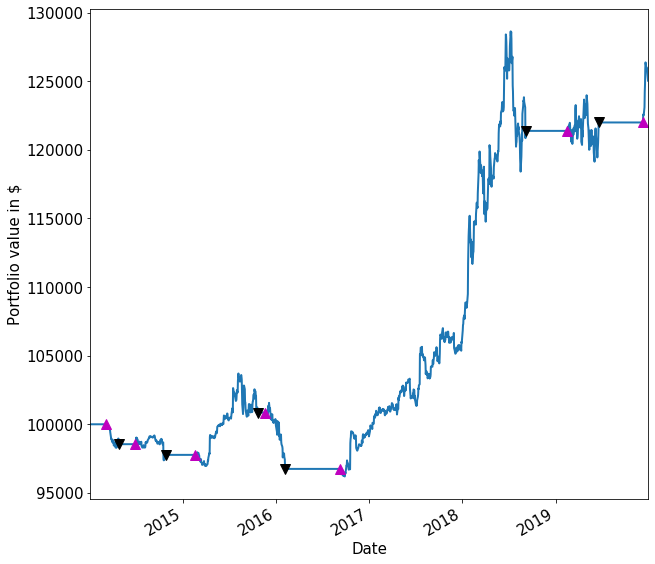

In [49]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

## Evaluating The Trading Strategy

### Sharpe Ratio

In [30]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.7386555830964753


### Maximum Drawdown

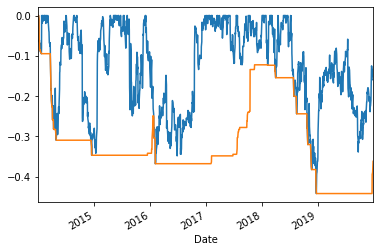

In [38]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = nflx['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = nflx['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

### Compound Annual Growth Rate (CAGR)

In [39]:
# Get the number of days in `aapl`
days = (nflx.index[-1] - nflx.index[0]).days

# Calculate the CAGR 
cagr = ((((nflx['Adj Close'][-1]) / nflx['Adj Close'][1])) ** (365.0/days)) - 1

# Print CAGR
print(cagr)

0.3569605026217406


### References : https://www.datacamp.com/community/tutorials/finance-python-trading